In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.model_selection import train_test_split
import unicodedata
import re
import numpy as np
import os
import io
import time

In [2]:
#Check Tensorflow execution
tf.executing_eagerly()

True

In [3]:
print(os.listdir("."))

['.config', 'hin.txt', '.ipynb_checkpoints', 'Checkpoints', 'sample_data']


In [4]:
path_to_file = "/content/hin.txt"

In [5]:
# Text preprocessing functions
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z\u0900-\u097f?.!,¿]+", " ", w)
    w = w.strip()
    w = '<start> ' + w + ' <end>'
    return w

In [6]:
# Example of sentence preprocessing
en_sentence = u"Help!"
hi_sentence = u"बचाओ!"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(hi_sentence))

<start> help ! <end>
<start> बचाओ ! <end>


In [7]:
# Create dataset function
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]] for l in lines[:num_examples]]
    return zip(*word_pairs)

In [8]:
# Tokenize and pad sequences
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor, lang_tokenizer

In [9]:
# Load dataset function
def load_dataset(path, num_examples=None):
    targ_lang, inp_lang = create_dataset(path, num_examples)
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [10]:
# Load and split the dataset
num_examples = 5000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 32
steps_per_epoch = len(input_tensor_train) // BATCH_SIZE
embedding_dim = 128
units = 512
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [11]:
# Define the Encoder
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [12]:
# Define the Attention Mechanism
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        hidden_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(
            self.W1(hidden_with_time_axis) + self.W2(values)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [13]:
# Define the Decoder
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        return x, state, attention_weights

In [14]:
# Initialize and define loss function
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
attention_layer = BahdanauAttention(10)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

optimizer = tf.keras.optimizers.Adam()

In [15]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [16]:
# Define the train_step function
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
        for t in range(1, targ.shape[1]):
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)
            dec_input = tf.expand_dims(targ[:, t], 1)
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [17]:
# Checkpoints
checkpoint_dir = '/content/Checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [18]:
# Training and validation
EPOCHS = 5
for epoch in range(EPOCHS):
    start = time.time()
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy():.4f}')

    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print(f'Epoch {epoch+1} Loss {total_loss/steps_per_epoch:.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec\n')

Epoch 1 Batch 0 Loss 2.3699
Epoch 1 Loss 1.6896
Time taken for 1 epoch 264.01 sec

Epoch 2 Batch 0 Loss 1.5814
Epoch 3 Batch 0 Loss 1.5036
Epoch 3 Loss 1.3617
Time taken for 1 epoch 200.78 sec

Epoch 4 Batch 0 Loss 1.3189
Epoch 4 Loss 1.2964
Time taken for 1 epoch 205.12 sec

Epoch 5 Batch 0 Loss 1.3443
Epoch 5 Loss 1.2351
Time taken for 1 epoch 216.44 sec



In [19]:
# Evaluate and translate functions
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = preprocess_sentence(sentence)
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    result = ''
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)
    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang.index_word[predicted_id] + ' '
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence, attention_plot

def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    fontdict = {'fontsize': 14}
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [20]:
# Restore the latest checkpoint and translate examples
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [21]:
for word in inp_lang.word_index:
  print(word)

<start>
<end>
ह।
म
?
ह
नही
वह
स
क
मझ
कया
को
की
हो
बहत
पर
का
उसन
एक
तम
था।
उस
यह
कर
लिए
मर
कि
,
न
तमह
मन
इस
और
हम
अपन
मरी
भी
रहा
पास
तो
करन
अपनी
गया।
कल
ही
काम
कोई
उसक
तमहार
उसकी
थी।
था
साथ
घर
करना
सकत
मरा
किताब
गया
बात
समय
रही
पता
आप
बज
बार
कहा
रह
!
कछ
आज
जान
चाहिए।
यहा
उसको
अभी
तक
लगता
मझस
थ।
पसद
अचछा
हई
दिया।
कभी
आ
सकता
मत
होता
दो
टॉम
अपना
किया।
करता
व
भारत
पस
गाडी
होती
करत
हो।
हए
उसस
हआ
दर
मदद
पहल
जयादा
होगा।
उसका
जो
साल
अगरजी
सार
चाहता
जब
जाना
गई।
अगर
गए
तमहारी
आपको
आदमी
किया
किसी
कम
जा
बाहर
वहा
सब
दी।
बद
छोड
चल
हमार
बडा
वापस
खाना
जाता
य
दिया
दिन
जलदी
फोन
लोग
कितन
रात
हर
बचच
करो।
कस
सकता।
तमन
शर
तरह
हमशा
बारिश
लोगो
जवाब
तमस
खतम
थ
दस
उनहोन
सकल
पापा
ठीक
आता
दोनो
चला
खश
अब
गए।
कयो
हमन
तीन
करती
डॉकटर
मौसम
दखा।
मशकिल
मा
पानी
दखा
दो।
ल
गई
कमर
हमारी
पिता
अचछी
सारी
टरन
होन
चाहत
सबस
मज
कोशिश
अचछ
कतता
दोसत
भाई
लिया।
थोडी
जाती
थोडा
या
चिटठी
थक
साफ
फिरस
बस
चीज
तमहारा
नही।
रहता
करी।
कब
जलद
लडकी
करनी
दख
दना
बिना
सबह
जनमदिन
यकीन
पढ
वाला
नौकरी
टीवी
बाद
बहन
पाच
छः
जापान
समझ
माफ
पयार
गलत
सभी
शहर
आपक

In [22]:
print(inp_lang.word_index)

{'<start>': 1, '<end>': 2, 'ह।': 3, 'म': 4, '?': 5, 'ह': 6, 'नही': 7, 'वह': 8, 'स': 9, 'क': 10, 'मझ': 11, 'कया': 12, 'को': 13, 'की': 14, 'हो': 15, 'बहत': 16, 'पर': 17, 'का': 18, 'उसन': 19, 'एक': 20, 'तम': 21, 'था।': 22, 'उस': 23, 'यह': 24, 'कर': 25, 'लिए': 26, 'मर': 27, 'कि': 28, ',': 29, 'न': 30, 'तमह': 31, 'मन': 32, 'इस': 33, 'और': 34, 'हम': 35, 'अपन': 36, 'मरी': 37, 'भी': 38, 'रहा': 39, 'पास': 40, 'तो': 41, 'करन': 42, 'अपनी': 43, 'गया।': 44, 'कल': 45, 'ही': 46, 'काम': 47, 'कोई': 48, 'उसक': 49, 'तमहार': 50, 'उसकी': 51, 'थी।': 52, 'था': 53, 'साथ': 54, 'घर': 55, 'करना': 56, 'सकत': 57, 'मरा': 58, 'किताब': 59, 'गया': 60, 'बात': 61, 'समय': 62, 'रही': 63, 'पता': 64, 'आप': 65, 'बज': 66, 'बार': 67, 'कहा': 68, 'रह': 69, '!': 70, 'कछ': 71, 'आज': 72, 'जान': 73, 'चाहिए।': 74, 'यहा': 75, 'उसको': 76, 'अभी': 77, 'तक': 78, 'लगता': 79, 'मझस': 80, 'थ।': 81, 'पसद': 82, 'अचछा': 83, 'हई': 84, 'दिया।': 85, 'कभी': 86, 'आ': 87, 'सकता': 88, 'मत': 89, 'होता': 90, 'दो': 91, 'टॉम': 92, 'अपना': 93, 'किया।': 94, 

Input: <start> उसस <end>
Predicted translation: i am a book . <end> 


<ipython-input-19-df38657ae781>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-19-df38657ae781>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2313 (\N{DEVANAGARI LETTER U}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


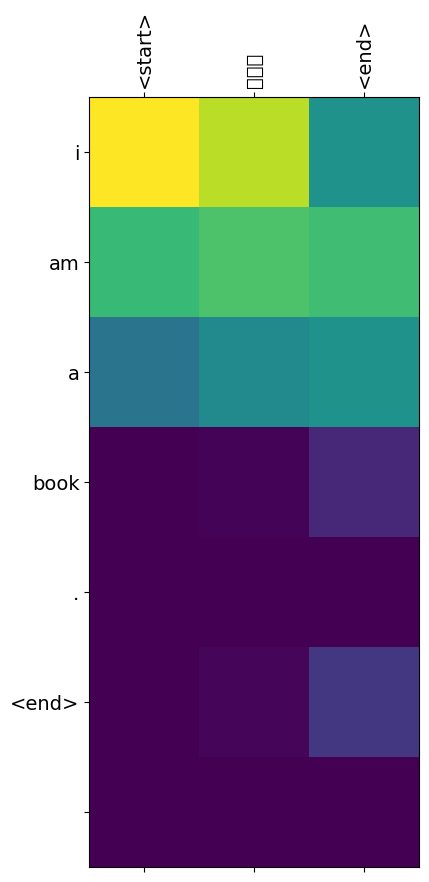

In [35]:
translate(u'उसस')

In [36]:
# Display confusion matrix, heatmap, result graph, learning accuracy, and training scores
def get_predictions(dataset):
    actuals, predictions = [], []
    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        enc_hidden = encoder.initialize_hidden_state()
        enc_out, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        for t in range(1, targ.shape[1]):
            predictions_batch, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_out)
            predicted_ids = tf.argmax(predictions_batch, axis=1).numpy()
            actuals.extend(targ[:, t].numpy())
            predictions.extend(predicted_ids)
            dec_input = tf.expand_dims(targ[:, t], 1)

    return actuals, predictions

In [37]:
actuals, predictions = get_predictions(dataset)

In [38]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(actuals, predictions, labels=list(range(vocab_tar_size)))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(targ_lang.word_index.keys()), yticklabels=list(targ_lang.word_index.keys()))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Accuracy
accuracy = accuracy_score(actuals, predictions)
print(f'Accuracy: {accuracy:.4f}')

In [ ]:
# Training Loss Graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, EPOCHS + 1), train_losses, marker='o', label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Return list of words and their predictions
def get_word_predictions(sentence):
    result, sentence, attention_plot = evaluate(sentence)
    words = sentence.split(' ')
    predictions = result.split(' ')
    return list(zip(words, predictions))

In [ ]:
# Example usage
word_predictions = get_word_predictions('ठीक')
print(word_predictions)